# Problem Statement

Schuster, a global retailer specializing in sports goods and accessories, works with hundreds of vendors under established credit terms. However, some vendors frequently miss payment deadlines, resulting in substantial late fees. While these fees impose a financial penalty, they’re ultimately detrimental to sustaining strong, long-term vendor relationships. Currently, Schuster dedicates resources to follow up on overdue payments, a process that adds limited value, consumes time, and incurs costs. The company now aims to analyze vendor payment behaviors and forecast the likelihood of delayed payments on outstanding invoices.


# Objective

- Schuster aims to gain deeper insights into vendor payment behaviors by analyzing historical payment patterns and segmenting its customers accordingly.
- By leveraging this historical data, Schuster wants to predict the probability of delayed payments on outstanding invoices.
- With these predictions, collectors can better prioritize follow-ups, proactively reaching out to vendors to ensure timely payments.

# 1. Importing Libraries and Data

In [1]:
#importing libraries and making some display settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_rows',500)

In [2]:
#importing warnings, effectively manages and addresses potential issues in the code, ensuring it is robust, maintainable, and compatible with future updates.
import warnings
warnings.filterwarnings('ignore')

In [3]:
#loading our Received_Payments_Data.csv into our df
df = pd.read_csv('Received_Payments_Data.csv')

#doing this step so that I can effectively see all columns in my dataset at once, along with the ability to glance the values in each column
pd.options.display.max_columns = None

#displaying the entire dataframe at once for the top 5 entries
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

## Basic EDA

- Let's start with some exploratory data analysis to understand underlying patterns.

In [5]:
#reading our dataframe into 'pdata'
pdata =pd.read_csv('Received_Payments_Data.csv')

In [6]:
#checking the number of rows and columns we have in our dataframe
pdata.shape

(93937, 16)

In [7]:
#checking if there are any null values
pdata.isnull().sum()

RECEIPT_METHOD            0
CUSTOMER_NAME             0
CUSTOMER_NUMBER           0
RECEIPT_DOC_NO           29
RECEIPT_DATE              0
CLASS                     0
CURRENCY_CODE             0
Local Amount              0
USD Amount                0
INVOICE_ALLOCATED         0
INVOICE_CREATION_DATE     0
DUE_DATE                  0
PAYMENT_TERM              0
INVOICE_CLASS             0
INVOICE_CURRENCY_CODE     0
INVOICE_TYPE              0
dtype: int64

In [8]:
#out of 93,00+ rows 29 rows have missing values for one column, let's explore the subset
pdata[pdata['RECEIPT_DOC_NO'].isnull()]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
93908,CHEQUE,SENS Corp,48486,NaN,8-Apr-21,PMT,AED,1443.43,1443.43,2.842E+11,16-Feb-21,30-Mar-21,30 Days from EOM,INV,AED,Goods
93909,WIRE,NAMS Corp,21145,NaN,1-Apr-21,PMT,AED,23574.33,23574.33,2.842E+11,24-Jan-21,24-Mar-21,60 Days from Inv Date,INV,AED,Goods
93910,WIRE,GRAN Corp,21312,NaN,8-Apr-21,PMT,USD,41793.60,41793.60,2.842E+11,22-Dec-20,20-Jan-21,30 Days from Inv Date,INV,USD,Goods
93911,WIRE,GRAN Corp,21312,NaN,8-Apr-21,PMT,USD,41793.60,41793.60,2.842E+11,28-Jan-21,28-Jan-21,Immediate,CM,USD,Goods
93912,WIRE,ANAN Corp,21251,NaN,8-Apr-21,PMT,USD,6398.74,6398.74,2.842E+11,11-Mar-21,10-Apr-21,30 Days from Inv Date,INV,AED,Goods
93913,WIRE,NAMS Corp,21145,NaN,7-Apr-21,PMT,AED,4342.99,4342.99,2.842E+11,26-Jan-21,26-Mar-21,60 Days from Inv Date,INV,AED,Goods
93914,WIRE,NAMS Corp,21145,NaN,7-Apr-21,PMT,AED,4342.99,4342.99,2.842E+11,26-Jan-21,26-Mar-21,60 Days from Inv Date,INV,AED,Goods
93915,WIRE,PEAR Corp,21144,NaN,1-Apr-21,PMT,USD,59914.50,59914.50,2.842E+11,4-Jan-21,28-Feb-21,60 Days from Inv Date,INV,USD,Goods
93916,WIRE,PEAR Corp,21144,NaN,1-Apr-21,PMT,USD,59914.50,59914.50,2.842E+11,7-Jan-21,7-Jan-21,Immediate,CM,USD,Goods
93917,WIRE,PEAR Corp,21144,NaN,1-Apr-21,PMT,USD,59914.50,59914.50,2.842E+11,7-Jan-21,7-Jan-21,Immediate,CM,USD,Goods


In [9]:
#let's see the value counts distribution for our categorical variables
pdata['RECEIPT_METHOD'].value_counts()

RECEIPT_METHOD
WIRE             84407
AP/AR Netting     4847
CHEQUE            3472
CASH               782
I/C WIRE           211
PDC                210
I/C Check            6
I/C CASH             2
Name: count, dtype: int64

In [10]:
pdata['CUSTOMER_NAME'].value_counts()

CUSTOMER_NAME
SEPH Corp    23143
FARO Corp    15004
PARF Corp     6624
ALLI Corp     5645
AREE Corp     2224
             ...  
KHAW Corp        1
EYEW Corp        1
BRAV Corp        1
NOUS Corp        1
ESSE Corp        1
Name: count, Length: 690, dtype: int64

In [11]:
pdata['CUSTOMER_NUMBER'].value_counts()

CUSTOMER_NUMBER
1409     14698
15768    11052
2315      9716
7530      5382
1888      5062
         ...  
34989        1
35032        1
51402        1
34956        1
2195         1
Name: count, Length: 1054, dtype: int64

In [12]:
#there are different lengths, this means that the Company Name has Multiple Customer Numbers
pdata.groupby(['CUSTOMER_NAME'])['CUSTOMER_NUMBER'].value_counts(ascending=True)

CUSTOMER_NAME  CUSTOMER_NUMBER
3D D Corp      4009               172
6TH  Corp      51440                9
A3 D Corp      23356                5
ABC  Corp      20965                3
ABDU Corp      34219                1
                                 ... 
ZAHR Corp      35012               13
ZAIN Corp      48682               20
               35013               22
ZERO Corp      44781                4
ZV F Corp      42660               11
Name: count, Length: 1054, dtype: int64

In [13]:
pdata.groupby(['CUSTOMER_NAME','CUSTOMER_NUMBER']).count()

RECEIPT_METHOD  RECEIPT_DOC_NO  RECEIPT_DATE  \
CUSTOMER_NAME CUSTOMER_NUMBER                                                 
3D D Corp     4009                        172             172           172   
6TH  Corp     51440                         9               9             9   
A3 D Corp     23356                         5               5             5   
ABC  Corp     20965                         3               3             3   
ABDU Corp     34219                         1               1             1   
...                                       ...             ...           ...   
ZAHR Corp     45445                         1               1             1   
ZAIN Corp     35013                        22              22            22   
              48682                        20              20            20   
ZERO Corp     44781                         4               4             4   
ZV F Corp     42660                        11              11            11   

                               CLASS  CURRENCY_CODE  Local Amount  USD Amount  \
CUSTOMER_NAME CUSTOMER_NUMBER                                                   
3D D Corp     4009               172            172           172         172   
6TH  Corp     51440                9              9             9           9   
A3 D Corp     23356                5              5             5           5   
ABC  Corp     20965                3              3             3           3   
ABDU Corp     34219                1              1             1           1   
...                              ...            ...           ...         ...   
ZAHR Corp     45445                1              1             1           1   
ZAIN Corp     35013               22             22            22          22   
              48682               20             20            20          20   
ZERO Corp     44781                4              4             4           4   
ZV F Corp     42660               11             11            11          11   

                               INVOICE_ALLOCATED  INVOICE_CREATION_DATE  \
CUSTOMER_NAME CUSTOMER_NUMBER                                             
3D D Corp     4009                           172                    172   
6TH  Corp     51440                            9                      9   
A3 D Corp     23356                            5                      5   
ABC  Corp     20965                            3                      3   
ABDU Corp     34219                            1                      1   
...                                          ...                    ...   
ZAHR Corp     45445                            1                      1   
ZAIN Corp     35013                           22                     22   
              48682                           20                     20   
ZERO Corp     44781                            4                      4   
ZV F Corp     42660                           11                     11   

                               DUE_DATE  PAYMENT_TERM  INVOICE_CLASS  \
CUSTOMER_NAME CUSTOMER_NUMBER                                          
3D D Corp     4009                  172           172            172   
6TH  Corp     51440                   9             9              9   
A3 D Corp     23356                   5             5              5   
ABC  Corp     20965                   3             3              3   
ABDU Corp     34219                   1             1              1   
...                                 ...           ...            ...   
ZAHR Corp     45445                   1             1              1   
ZAIN Corp     35013                  22            22             22   
              48682                  20            20             20   
ZERO Corp     44781                   4             4              4   
ZV F Corp     42660                  11            11             11   

                               INVOI

In [14]:
#making our column into datetime format to be further used for analysis
pdata['RECEIPT_DATE']=pd.to_datetime(pdata['RECEIPT_DATE'], format='%d-%b-%y')
pdata['RECEIPT_DATE']

0       2021-04-20
1       2021-01-31
2       2021-01-31
3       2021-01-31
4       2021-01-31
           ...    
93932   2021-04-01
93933   2021-04-01
93934   2021-04-01
93935   2021-04-01
93936   2021-04-08
Name: RECEIPT_DATE, Length: 93937, dtype: datetime64[ns]

In [15]:
pdata['CLASS'].value_counts()

CLASS
PMT    93937
Name: count, dtype: int64

In [16]:
#since it has only 1 value and no variation, we will drop it
pdata.drop(['CLASS'], axis=1, inplace=True)
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         93937 non-null  object        
 1   CUSTOMER_NAME          93937 non-null  object        
 2   CUSTOMER_NUMBER        93937 non-null  int64         
 3   RECEIPT_DOC_NO         93908 non-null  float64       
 4   RECEIPT_DATE           93937 non-null  datetime64[ns]
 5   CURRENCY_CODE          93937 non-null  object        
 6   Local Amount           93937 non-null  float64       
 7   USD Amount             93937 non-null  float64       
 8   INVOICE_ALLOCATED      93937 non-null  object        
 9   INVOICE_CREATION_DATE  93937 non-null  object        
 10  DUE_DATE               93937 non-null  object        
 11  PAYMENT_TERM           93937 non-null  object        
 12  INVOICE_CLASS          93937 non-null  object        
 13  I

In [17]:
pdata['CURRENCY_CODE'].value_counts()

CURRENCY_CODE
SAR    36495
AED    36279
USD    19524
EUR     1438
GBP      130
BHD       59
KWD       10
QAR        2
Name: count, dtype: int64

<AxesSubplot:ylabel='Local Amount'>

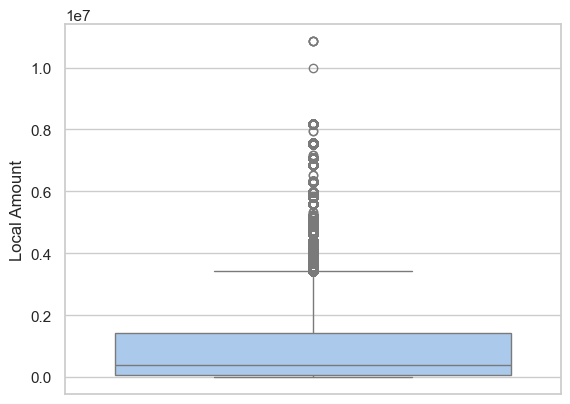

In [18]:
#let's check outliers if any when it comes to local amount
sns.boxplot(pdata['Local Amount'])

<AxesSubplot:ylabel='USD Amount'>

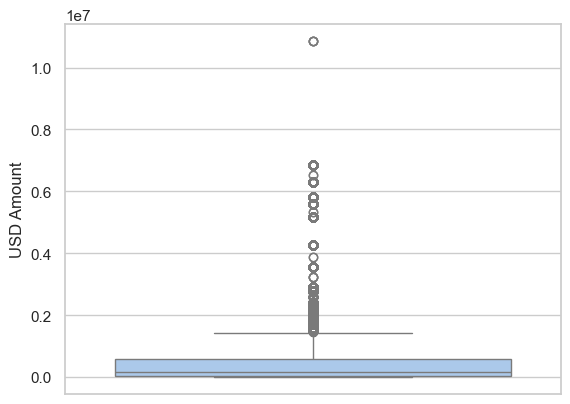

In [19]:
#let's check for USD Amount as well
sns.boxplot(pdata['USD Amount'])

In [20]:
#checking extreme values in the data
pdata[pdata['USD Amount']>10000000]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
60057,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,3-Jan-21,3-Jan-21,Immediate Payment,INV,AED,Non Goods
60058,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,14-Feb-21,14-Feb-21,Immediate Payment,INV,AED,Non Goods
60059,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,26-Jan-21,26-Jan-21,Immediate Payment,INV,AED,Non Goods
60060,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,12-Jan-21,12-Jan-21,Immediate Payment,INV,AED,Non Goods


Here, we can see that local amount and USD amount is the same. Let's explore where is this similar pattern observed in the data.

In [21]:
#checking where Local and USD Values are same 
len(pdata[pdata['Local Amount']==pdata['USD Amount']])

41624

There are more than 41,000 Entries where local and USD values are the same.

In [22]:
#checking where Currency Code is not USD
len(pdata[pdata['Local Amount']==pdata['USD Amount']][pdata['CURRENCY_CODE']!='USD'])

22769

We have 22,000+ entries here.

In [23]:
#checking different Currency Codes where it is not USD
pdata[pdata['Local Amount']==pdata['USD Amount']][pdata['CURRENCY_CODE']!='USD']['CURRENCY_CODE'].value_counts()

CURRENCY_CODE
AED    20534
EUR     1365
SAR      727
GBP      130
KWD       10
QAR        2
BHD        1
Name: count, dtype: int64

We can see that majority of the values are in AED.

In [24]:
#Checking in which Currency was the Invoice Raised
pdata[pdata['Local Amount']==pdata['USD Amount']][pdata['CURRENCY_CODE']!='USD']['INVOICE_CURRENCY_CODE'].value_counts()

INVOICE_CURRENCY_CODE
AED    15850
SAR     2890
USD     2250
EUR     1358
KWD      144
GBP      129
BHD      104
JOD       28
QAR       16
Name: count, dtype: int64

From this we can infer that there might be a lot over lapping.
Moving forward, we will Consider the USD amount Data as the correct invoice amount for the entire data set.

In [25]:
#checking the Outliers of Payment above 10 million
pdata[pdata['USD Amount']>10000000]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
60057,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,3-Jan-21,3-Jan-21,Immediate Payment,INV,AED,Non Goods
60058,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,14-Feb-21,14-Feb-21,Immediate Payment,INV,AED,Non Goods
60059,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,26-Jan-21,26-Jan-21,Immediate Payment,INV,AED,Non Goods
60060,WIRE,SEPH Corp,2315,1.560000e+11,2021-02-16,AED,10849828.8,10849828.8,1.5621E+11,12-Jan-21,12-Jan-21,Immediate Payment,INV,AED,Non Goods


In [26]:
#dropping the 4 values above 10 million
dropindex=pdata[pdata['USD Amount']>10000000].index
pdata.drop(dropindex,inplace=True)

#checking the info about the dataframe retained
pdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93933 entries, 0 to 93936
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         93933 non-null  object        
 1   CUSTOMER_NAME          93933 non-null  object        
 2   CUSTOMER_NUMBER        93933 non-null  int64         
 3   RECEIPT_DOC_NO         93904 non-null  float64       
 4   RECEIPT_DATE           93933 non-null  datetime64[ns]
 5   CURRENCY_CODE          93933 non-null  object        
 6   Local Amount           93933 non-null  float64       
 7   USD Amount             93933 non-null  float64       
 8   INVOICE_ALLOCATED      93933 non-null  object        
 9   INVOICE_CREATION_DATE  93933 non-null  object        
 10  DUE_DATE               93933 non-null  object        
 11  PAYMENT_TERM           93933 non-null  object        
 12  INVOICE_CLASS          93933 non-null  object        
 13  INVOIC

### Changing to Date Time Format
- Changing all the columns that are actually dates but stored in object format to datetime format to be used for our analysis purpose.

In [27]:
pdata['INVOICE_CREATION_DATE']=pd.to_datetime(pdata['INVOICE_CREATION_DATE'], format='%d-%b-%y')
pdata['DUE_DATE']=pd.to_datetime(pdata['DUE_DATE'], format='%d-%b-%y')

In [28]:
#creating new features
pdata['CREDIT_DAYS']=pdata['DUE_DATE']-pdata['INVOICE_CREATION_DATE']
pdata["DAYS_LATE"]=pdata['RECEIPT_DATE']-pdata['DUE_DATE']
pdata['DAYS_LATE']=pd.to_numeric(pdata['DAYS_LATE'].dt.days, downcast='integer')

In [29]:
#creating our boolean column based on condition
pdata["LATE"] = pdata["DAYS_LATE"]>0

In [30]:
#replace categorical binary values to integer binary
pdata['LATE'] = pdata['LATE'].replace({"True":1, "False":0})
pdata['LATE'].mean()

0.6597681326051548

We can see that nearly 66% of the payments are late. That means 2 in every 3 make late payments.

<AxesSubplot:xlabel='DAYS_LATE', ylabel='Count'>

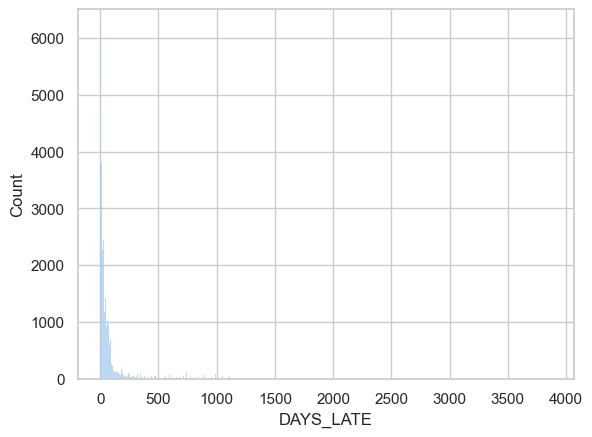

In [31]:
#displaying the distribution of people who have been late
sns.histplot(data=pdata[pdata['LATE']==1],x='DAYS_LATE')

In [32]:
#seeing the statistical properties of our column
pdata['DAYS_LATE'].describe()

count    93933.000000
mean        70.742306
std        204.415671
min       -340.000000
25%         -4.000000
50%         12.000000
75%         49.000000
max       3873.000000
Name: DAYS_LATE, dtype: float64

<AxesSubplot:xlabel='DAYS_LATE'>

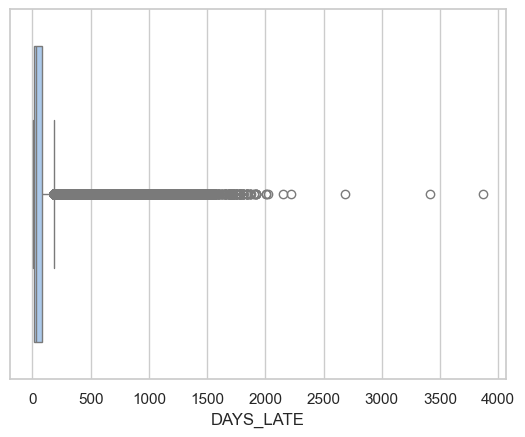

In [33]:
#checking if theare are outliers 
sns.boxplot(data=pdata[pdata['LATE']==1],x='DAYS_LATE')

<AxesSubplot:xlabel='DAYS_LATE'>

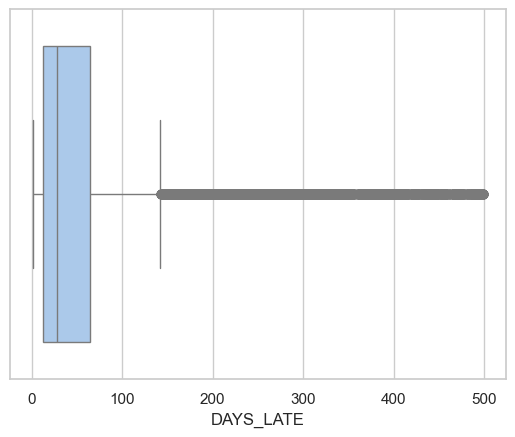

In [34]:
#creating boxplot for the subrange which seems to be where the maximum distribution lies
sns.boxplot(data=pdata[(pdata['DAYS_LATE']<500) & (pdata['DAYS_LATE']>0)], x='DAYS_LATE')

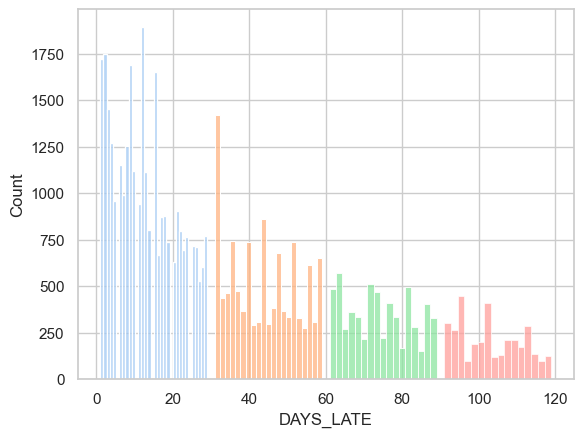

In [35]:
#we will have to Bin the Data
for x in [30,60,90,120]:
    sns.histplot(data=pdata[(pdata['DAYS_LATE']<x) & (pdata['DAYS_LATE']>(x-30))], x='DAYS_LATE')

In [36]:
#binning our data
pdata['DELAY']=pd.cut(pdata['DAYS_LATE'], [-400,0,15,30,60,90,180,365,4000],
                   labels=['No Delay', '2 Weeks', 'Month', '2 Months', '3 Months',
                          '6 Months', 'Year', 'More than Year'])
pdata.DELAY.value_counts(normalize=True)

DELAY
No Delay          0.340232
2 Weeks           0.210235
2 Months          0.120426
Month             0.118957
3 Months          0.065738
More than Year    0.060213
6 Months          0.056892
Year              0.027307
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Delay in Payment')

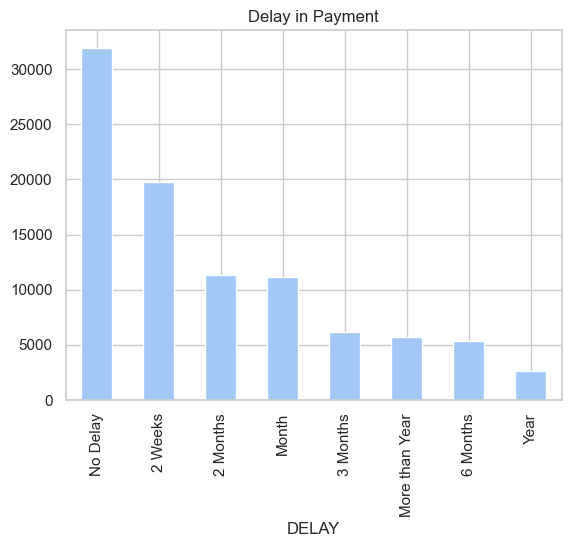

In [37]:
#let's visualise the delay in payment
pdata.DELAY.value_counts().plot.bar()
plt.title('Delay in Payment')

In [38]:
#let's see the frequency of payment terms
terms_freq=pdata['PAYMENT_TERM'].value_counts(normalize=True)
terms_freq*100

PAYMENT_TERM
60 Days from Inv Date                                      21.153375
30 Days from Inv Date                                      15.619644
60 Days from EOM                                           13.326520
30 Days from EOM                                           12.036239
15 Days from EOM                                            8.031256
Immediate Payment                                           5.823300
Immediate                                                   5.600801
90 Days from EOM                                            4.144443
45 Days from Inv Date                                       3.779289
45 Days from EOM                                            3.735641
90 Days from Inv Date                                       2.353805
100% Adv Payment                                            1.321154
25 DAYS FROM EOM                                            0.491840
Cash on Delivery                                            0.444998
15 Days from Inv Date

We can see that a lot of Terms have very low Frequency.

In [39]:
#let's create a copy of our dataframe for further use.
df_pay = pdata

In [40]:
df_pay['PAYMENT_TERM'].value_counts()

PAYMENT_TERM
60 Days from Inv Date                                      19870
30 Days from Inv Date                                      14672
60 Days from EOM                                           12518
30 Days from EOM                                           11306
15 Days from EOM                                            7544
Immediate Payment                                           5470
Immediate                                                   5261
90 Days from EOM                                            3893
45 Days from Inv Date                                       3550
45 Days from EOM                                            3509
90 Days from Inv Date                                       2211
100% Adv Payment                                            1241
25 DAYS FROM EOM                                             462
Cash on Delivery                                             418
15 Days from Inv Date                                        356
45 DAYS + EO

In [41]:
#cleaning 'PAYMENT_TERM' values based on identified categories

#defining a mapping dictionary for efficient replacement
payment_term_mapping = {
    # Immediate Payment terms
    'Immediate Payment': 'Immediate',
    'Cash on Delivery': 'Immediate',
    'On Consignment': 'Immediate',
    'Cash Against Document at sight': 'Immediate',
    
    # Partial Advance or Letter of Credit (LC) terms
    'Advance with discount': 'Partial Adv/LC',
    '25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE': 'Partial Adv/LC',
    '30% advance 70% after 30 days from invoice date': 'Partial Adv/LC',
    '50% ADVANCE PAYMENT AND 50% UPON RECEIVING THE SHIPMENT': 'Partial Adv/LC',
    '30% advance 70% after 60 days from invoice date': 'Partial Adv/LC',
    '50% ADV 50% 30 Days': 'Partial Adv/LC',
    '50% Advance 50% INVDATE+60 DAYS': 'Partial Adv/LC',
    'LC at 60 days': 'Partial Adv/LC',
    'LCSight': 'Partial Adv/LC',
    'LC at 90 days': 'Partial Adv/LC',
    'LC at 60 days from FCR/AWB/BL date': 'Partial Adv/LC',
    'Standby LC at 30 days': 'Partial Adv/LC',
    
    # Advance Payment (full or partial) terms
    '100% Adv Payment': 'Part/Full Adv+LC',
    'Partial Adv/LC': 'Part/Full Adv+LC',
    
    # Extended payment terms over 90 days
    '90 Days from Inv Date': '90+ Days from Inv Date',
    '120 Days from Inv Date': '90+ Days from Inv Date',
    '195 days from Invoice Date': '90+ Days from Inv Date',
    '365 DAYS FROM INVOICE DATE': '90+ Days from Inv Date',
    '180 DAYS FROM INV DATE': '90+ Days from Inv Date',
    '75 Days from EOM': '90+ Days from Inv Date',
    '120 Days from EOM': '90+ Days from Inv Date',
    
    # 45-day terms
    '45 DAYS + EOM': '45 Days from EOM',
    '40 DAYS FROM EOM': '45 Days from EOM',
    
    # 30-day terms
    '25 DAYS FROM EOM': '30 Days from EOM',
    '15 Days from Inv Date': '30 Days from Inv Date',
    '7 Days from Inv Date': '30 Days from Inv Date',
    'EOM': '30 Days from Inv Date',
    '7 Days from EOM': '30 Days from Inv Date',
    
    # 90-day terms
    '75 Days from Inv Date': '90 Days from EOM',
    
    # 60-day terms
    '50% at 30 days and 50% at 60 days': '60 Days from Inv Date'
}

# Apply the mapping to the 'PAYMENT_TERM' column
df_pay['PAYMENT_TERM'] = df_pay['PAYMENT_TERM'].replace(payment_term_mapping)

In [42]:
#let's check the distribution now
df_pay['PAYMENT_TERM'].value_counts()

PAYMENT_TERM
60 Days from Inv Date     19872
30 Days from Inv Date     15307
60 Days from EOM          12518
30 Days from EOM          11768
Immediate                 11419
15 Days from EOM           7544
90 Days from EOM           3952
45 Days from EOM           3833
45 Days from Inv Date      3550
90+ Days from Inv Date     2562
Part/Full Adv+LC           1241
Partial Adv/LC              367
Name: count, dtype: int64

 We have managed to reduce the payment terms. Let's now plot this against our late column to see trends.

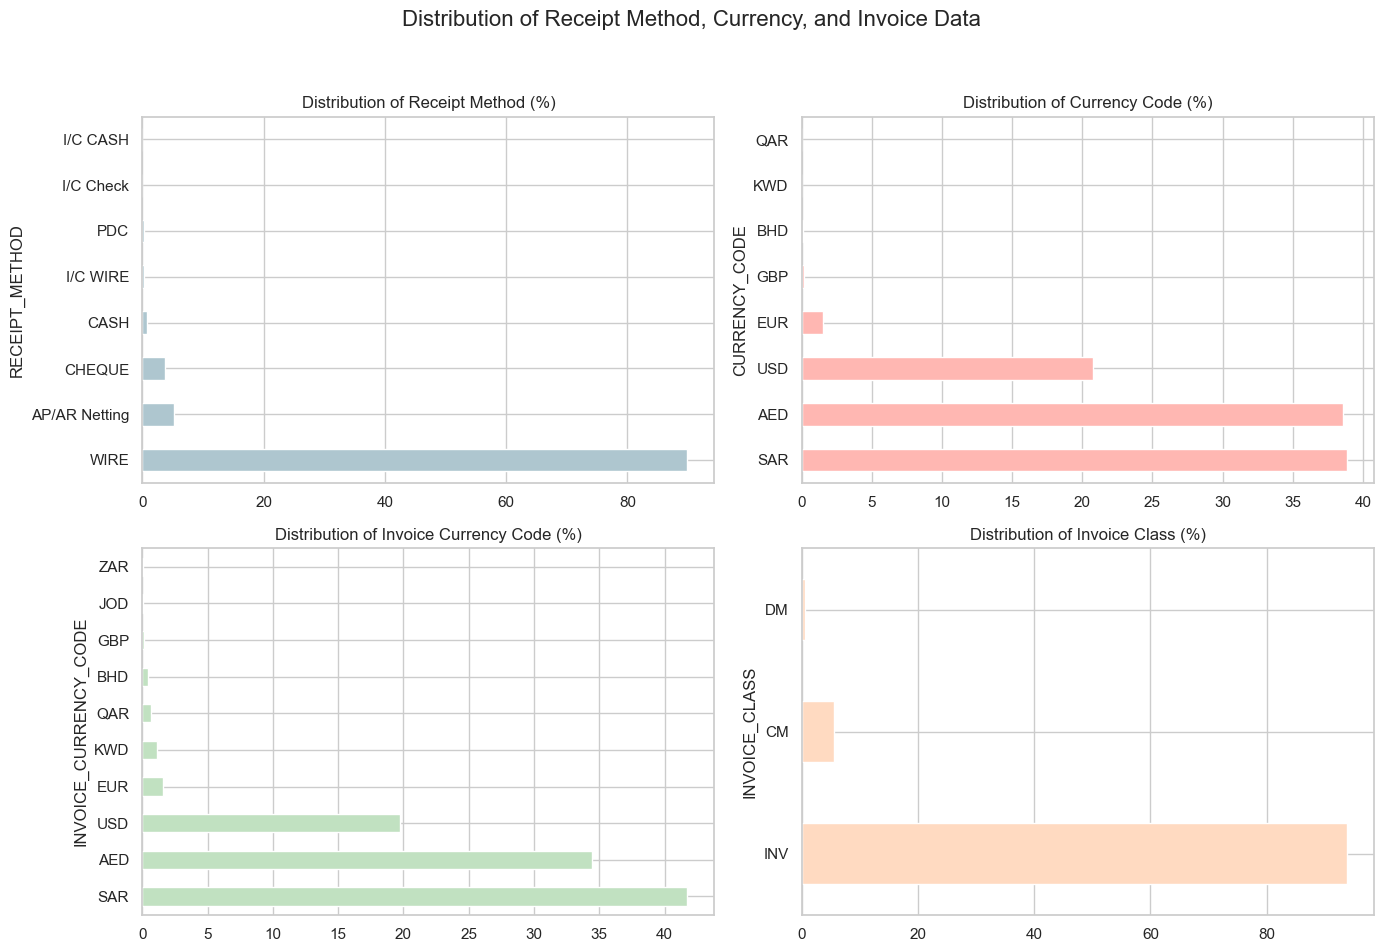

In [43]:
#visualizing patterns

#setting up subplots for the distributions in one figure
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
fig1.suptitle('Distribution of Receipt Method, Currency, and Invoice Data', fontsize=16)

#pastel color scheme
pastel_colors = ['#AEC6CF', '#FFB7B2', '#C1E1C1', '#FFDAC1']

#distribution of receipt method
(df_pay['RECEIPT_METHOD'].value_counts(normalize=True) * 100).plot.barh(ax=axes1[0, 0], color=pastel_colors[0])
axes1[0, 0].set_title('Distribution of Receipt Method (%)')

#distribution of currency code
(df_pay['CURRENCY_CODE'].value_counts(normalize=True) * 100).plot.barh(ax=axes1[0, 1], color=pastel_colors[1])
axes1[0, 1].set_title('Distribution of Currency Code (%)')

#distribution of invoice currency code
(df_pay['INVOICE_CURRENCY_CODE'].value_counts(normalize=True) * 100).plot.barh(ax=axes1[1, 0], color=pastel_colors[2])
axes1[1, 0].set_title('Distribution of Invoice Currency Code (%)')

#distribution of invoice class
(df_pay['INVOICE_CLASS'].value_counts(normalize=True) * 100).plot.barh(ax=axes1[1, 1], color=pastel_colors[3])
axes1[1, 1].set_title('Distribution of Invoice Class (%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


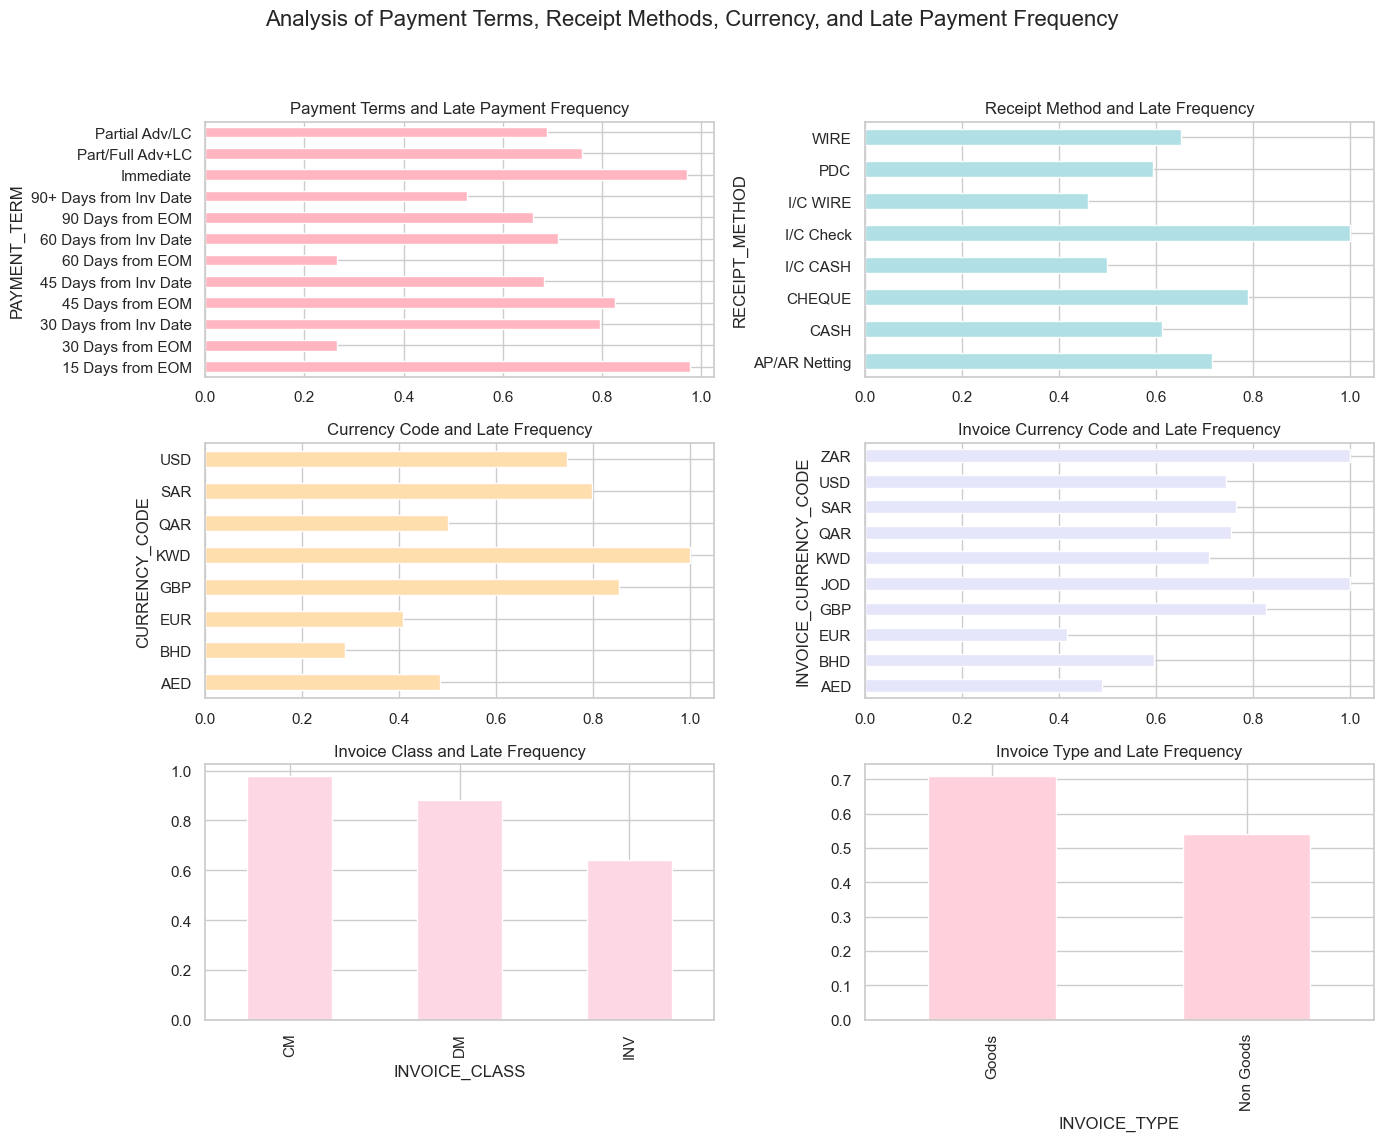

In [44]:
#visualising Payment Terms, Receipt Methods, Currency, and Late Payment Frequency

#setting up subplots for the 'LATE' column analysis in a second figure
fig2, axes2 = plt.subplots(3, 2, figsize=(14, 12))
fig2.suptitle('Analysis of Payment Terms, Receipt Methods, Currency, and Late Payment Frequency', fontsize=16)

#defining more pastel colors for the second set of plots
pastel_colors_2 = ['#FFB6C1', '#B0E0E6', '#FFDEAD', '#E6E6FA', '#FDD7E4', '#FFD1DC']

#payment terms vs late payments
df_pay.groupby('PAYMENT_TERM')['LATE'].mean().plot.barh(ax=axes2[0, 0], color=pastel_colors_2[0])
axes2[0, 0].set_title('Payment Terms and Late Payment Frequency')

#receipt method vs late payments
df_pay.groupby('RECEIPT_METHOD')['LATE'].mean().plot.barh(ax=axes2[0, 1], color=pastel_colors_2[1])
axes2[0, 1].set_title('Receipt Method and Late Frequency')

#currency code vs late payments
df_pay.groupby('CURRENCY_CODE')['LATE'].mean().plot.barh(ax=axes2[1, 0], color=pastel_colors_2[2])
axes2[1, 0].set_title('Currency Code and Late Frequency')

#invoice currency code vs late payments
df_pay.groupby('INVOICE_CURRENCY_CODE')['LATE'].mean().plot.barh(ax=axes2[1, 1], color=pastel_colors_2[3])
axes2[1, 1].set_title('Invoice Currency Code and Late Frequency')

#invoice class vs late payments
df_pay.groupby('INVOICE_CLASS')['LATE'].mean().plot.bar(ax=axes2[2, 0], color=pastel_colors_2[4])
axes2[2, 0].set_title('Invoice Class and Late Frequency')

#invoice type vs late payments
df_pay.groupby('INVOICE_TYPE')['LATE'].mean().plot.bar(ax=axes2[2, 1], color=pastel_colors_2[5])
axes2[2, 1].set_title('Invoice Type and Late Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Checking Top Customers

In [45]:
#checking frequency of customers
cust_freq=df_pay['CUSTOMER_NUMBER'].value_counts(normalize=True)
cust_freq

CUSTOMER_NUMBER
1409     0.156473
15768    0.117658
2315     0.103393
7530     0.057296
1888     0.053889
           ...   
34989    0.000011
35032    0.000011
51402    0.000011
34956    0.000011
2195     0.000011
Name: proportion, Length: 1054, dtype: float64

In [46]:
#checking first 30 values as it seems to have the majority
cust_freq.cumsum().head(30)

CUSTOMER_NUMBER
1409     0.156473
15768    0.274132
2315     0.377524
7530     0.434821
1888     0.488710
3274     0.512291
3926     0.534998
34870    0.550754
1044     0.565350
3997     0.579062
2795     0.587972
3694     0.596851
7567     0.605559
15766    0.614161
23296    0.621943
4003     0.629544
3927     0.636539
1679     0.643203
1825     0.649016
20998    0.654743
4791     0.660268
3925     0.665740
3685     0.671149
2273     0.676227
15767    0.681134
3079     0.685861
3409     0.689843
48842    0.693814
38032    0.697540
2274     0.701138
Name: proportion, dtype: float64

We can see that 70% Of the Business Comes from top 30 Customer Numbers.

In [47]:
#let's create a dataframe for the top customers
top_30=cust_freq.head(30)
top_cust=pd.DataFrame(top_30)
top_cust.index

#create subset of dataframe for top customers
top_cust_df=df_pay[df_pay['CUSTOMER_NUMBER'].isin(top_cust.index)]

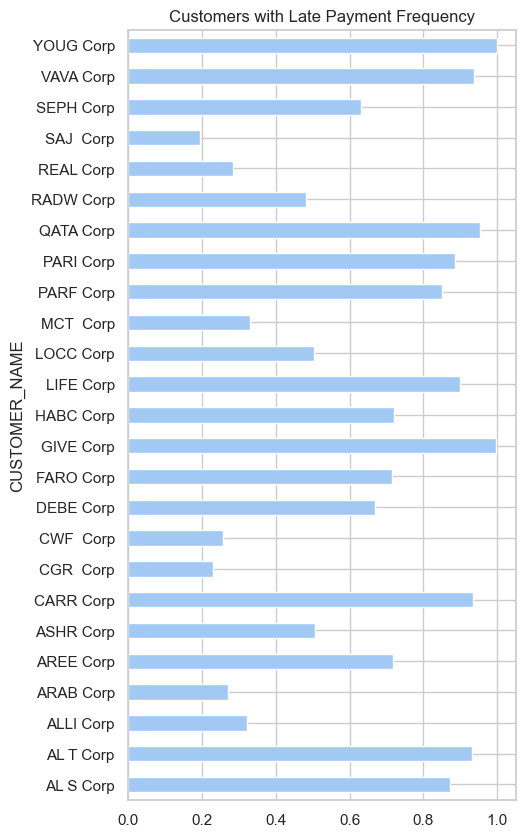

In [48]:
#visualising distribution of customers with Late Frequency
plt.figure(figsize=(5,10))
top_cust_df.groupby(['CUSTOMER_NAME'])['LATE'].mean().plot.barh()
plt.title('Customers with Late Payment Frequency')
plt.show()

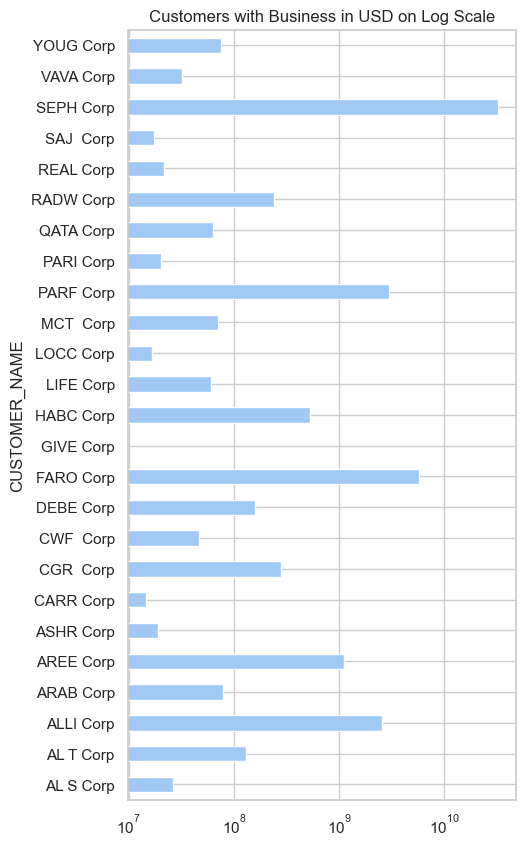

In [49]:
#visualising distribution of customers with business in USD using Log Scale
plt.figure(figsize=(5,10))
(top_cust_df.groupby(['CUSTOMER_NAME'])['USD Amount'].sum()).plot.barh()
plt.xscale('log')
plt.title('Customers with Business in USD on Log Scale')
plt.show()

# 2. Data cleaning

In [50]:
#checking for missing values in our original dataframe
df.isnull().sum()

RECEIPT_METHOD            0
CUSTOMER_NAME             0
CUSTOMER_NUMBER           0
RECEIPT_DOC_NO           29
RECEIPT_DATE              0
CLASS                     0
CURRENCY_CODE             0
Local Amount              0
USD Amount                0
INVOICE_ALLOCATED         0
INVOICE_CREATION_DATE     0
DUE_DATE                  0
PAYMENT_TERM              0
INVOICE_CLASS             0
INVOICE_CURRENCY_CODE     0
INVOICE_TYPE              0
dtype: int64

In [51]:
#checking number of unique values in each column
for i in df.columns:
    print(i, ':',len(df[i].unique()))

RECEIPT_METHOD : 8
CUSTOMER_NAME : 690
CUSTOMER_NUMBER : 1054
RECEIPT_DOC_NO : 74
RECEIPT_DATE : 170
CLASS : 1
CURRENCY_CODE : 8
Local Amount : 7752
USD Amount : 7820
INVOICE_ALLOCATED : 12986
INVOICE_CREATION_DATE : 1310
DUE_DATE : 1203
PAYMENT_TERM : 42
INVOICE_CLASS : 3
INVOICE_CURRENCY_CODE : 10
INVOICE_TYPE : 2


Examining the dataframe to identify missing and unique values.
- Dropping columns RECEIPT_DOC_NO and RECEIPT_METHOD due to missing values and perceived lack of significance.
- Removing CLASS since it has the same value across all rows.
- Dropping CURRENCY_CODE and Local Amount as INVOICE_CURRENCY_CODE and USD Amount are already available for currency details.
- Excluding CUSTOMER_NUMBER and INVOICE_ALLOCATED due to limited relevance.

In [52]:
#dropping unnecessary columns as discussed
df1 = df.drop(['RECEIPT_METHOD', 'CUSTOMER_NUMBER','RECEIPT_DOC_NO','CLASS','CURRENCY_CODE', 
               'Local Amount','INVOICE_ALLOCATED'],axis=1)

In [53]:
#converting date columns to date time format like earlier
df1[['RECEIPT_DATE','INVOICE_CREATION_DATE','DUE_DATE']] = df1[['RECEIPT_DATE','INVOICE_CREATION_DATE','DUE_DATE']].apply(pd.to_datetime)

In [54]:
#adding new feature column with overdue days
df1['overdue_days'] = df1['RECEIPT_DATE']-df1['DUE_DATE']

#converting overdue_days to int format
df1['overdue_days'] = df1['overdue_days'].dt.days

In [55]:
#adding target column, where overdue_days>0 is 1 (payment delayed) and overdue_days<=0 is 0 (payment not delayed)
df1['target'] = np.where(df1['overdue_days']>0,1,0)

In [56]:
#adding credit_period indicating number of days from invoice date to due date.
df1['credit_period'] = (df1['DUE_DATE']-df1['INVOICE_CREATION_DATE']).dt.days

In [57]:
#displaying the first few rows of our dataframe
df1.head(5)

,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,overdue_days,target,credit_period
0,C EA Corp,2021-04-20,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,111,1,58
1,RADW Corp,2021-01-31,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,3,1,30
2,RADW Corp,2021-01-31,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,-29,0,30
3,FARO Corp,2021-01-31,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,1,30
4,RADW Corp,2021-01-31,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,1,30


# 3. Clustering

### 3.1 Importing libraries for clustering

In [58]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 3.2 Data Preparation for clustering

In [59]:
#getting average credit_period
grouped_df = df1.groupby('CUSTOMER_NAME')['credit_period'].mean()
grouped_df = grouped_df.reset_index()
grouped_df.columns = ['CUSTOMER_NAME','credit_period_avg']

#displaying the first few rows of the new dataframe
grouped_df.head(3)

,CUSTOMER_NAME,credit_period_avg
0,3D D Corp,32.372093
1,6TH Corp,78.444444
2,A3 D Corp,26.600000


In [60]:
#getting credit_period standard deviation
stddev = df1.groupby('CUSTOMER_NAME')['credit_period'].std()
stddev = stddev.reset_index()
stddev.columns = ['CUSTOMER_NAME','credit_period_sd']


#displaying the first few rows of the new dataframe
stddev.head(3)

,CUSTOMER_NAME,credit_period_sd
0,3D D Corp,15.387431
1,6TH Corp,7.264832
2,A3 D Corp,2.190890


In [61]:
#now merging to get dataframe with CUSTOMER_NAME, credit_period_avg, credit_period_sd
grouped_df = pd.merge(grouped_df, stddev, on='CUSTOMER_NAME',how='inner')

#displaying the first few rows of the new dataframe
grouped_df.head()

,CUSTOMER_NAME,credit_period_avg,credit_period_sd
0,3D D Corp,32.372093,15.387431
1,6TH Corp,78.444444,7.264832
2,A3 D Corp,26.600000,2.190890
3,ABC Corp,90.000000,0.000000
4,ABDU Corp,70.941406,30.821187


In [62]:
#check statastical information for numerical variables 
grouped_df.describe()

,credit_period_avg,credit_period_sd
count,690.000000,604.000000
mean,38.570561,13.196848
std,32.516411,28.991577
min,-496.233405,0.000000
25%,27.627835,0.000000
50%,38.968085,8.061699
75%,55.927885,20.241019
max,120.000000,471.333073


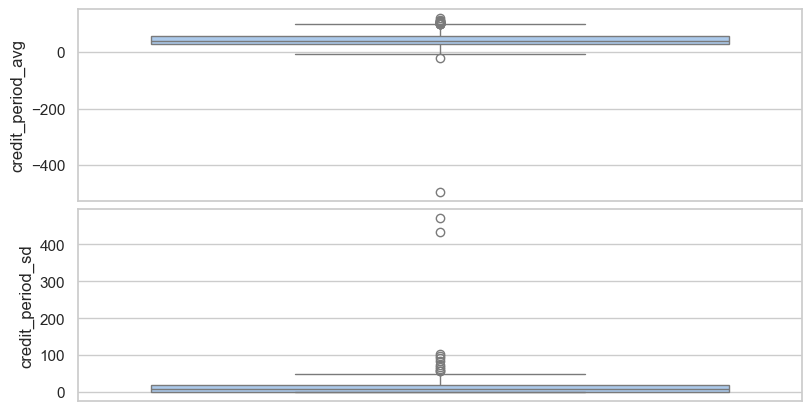

In [63]:
#plotting credit_period_avg, credit_period_sd to check for outliers
plt.figure(figsize=[8,4],layout='constrained')
plt.subplot(2,1,1)
sns.boxplot(grouped_df.credit_period_avg)
plt.subplot(2,1,2)
sns.boxplot(grouped_df.credit_period_sd)
plt.show()

In [64]:
#let's now remove outliers using IQR
#outlier treatment for credit_period_avg
Q1 = grouped_df.credit_period_avg.quantile(0.05)
Q3 = grouped_df.credit_period_avg.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.credit_period_avg >= Q1 - 1.5*IQR) & (grouped_df.credit_period_avg <= Q3 + 1.5*IQR)]

#outlier treatment for payment_days_sd
Q1 = grouped_df.credit_period_sd.quantile(0.05)
Q3 = grouped_df.credit_period_sd.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.credit_period_sd >= Q1 - 1.5*IQR) & (grouped_df.credit_period_sd <= Q3 + 1.5*IQR)]

In [65]:
#Keeping numerical variables for scaling
pd_df = grouped_df[['credit_period_avg', 'credit_period_sd']]

#instantiate scaling
scaler = StandardScaler()
pd_df_scaled = scaler.fit_transform(pd_df)

#checking shape of scaled dataframe
pd_df_scaled.shape

(599, 2)

In [66]:
#creating dataframe 
pd_df_scaled = pd.DataFrame(pd_df_scaled)

#column names of the dataframe
pd_df_scaled.columns = ['credit_period_avg', 'credit_period_sd']

#displaying first few rows of the dataframe
pd_df_scaled.head(5)


,credit_period_avg,credit_period_sd
0,-0.314178,0.319684
1,1.561517,-0.317138
2,-0.549171,-0.714941
3,2.031966,-0.886709
4,1.256053,1.529710


### 3.3 Appying K-Means Clustering

In [67]:
#let's fit a k-means with some arbitrary k
kmeans = KMeans(n_clusters=5, max_iter=100)
kmeans.fit(pd_df_scaled)

KMeans(max_iter=100, n_clusters=5)

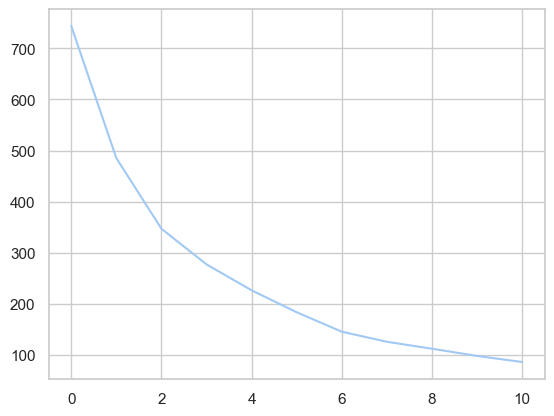

In [68]:
#plot the elbow-curve
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter=100)
    kmeans.fit(pd_df_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(ssd)
plt.show()

#### Silhouette analysis

In [69]:
#let's now do silhouette analysis
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters,max_iter = 100)
    kmeans.fit(pd_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(pd_df_scaled, cluster_labels)
    print('For n_clusters={0}, the silhouette score is {1}'.format(num_clusters,silhouette_avg))

For n_clusters=2, the silhouette score is 0.39279072910766427
For n_clusters=3, the silhouette score is 0.3973254448249424
For n_clusters=4, the silhouette score is 0.4631100442617391
For n_clusters=5, the silhouette score is 0.4380160167482847
For n_clusters=6, the silhouette score is 0.45059789940393674
For n_clusters=7, the silhouette score is 0.45576274662587396
For n_clusters=8, the silhouette score is 0.4782646351027327
For n_clusters=9, the silhouette score is 0.47744417170550285
For n_clusters=10, the silhouette score is 0.5015907462261696
For n_clusters=11, the silhouette score is 0.5260463229436907
For n_clusters=12, the silhouette score is 0.5299641595040113


As we can see, We will go with k=4 as the score is close to 0.46. There are score greater than this as well for clusters 8 to 12, however, too many cluster will loose its importance.

In [70]:
#let's fit with 4 clusters now
kmeans = KMeans(n_clusters=4,max_iter=100)
kmeans.fit(pd_df_scaled)

KMeans(max_iter=100, n_clusters=4)

In [71]:
#assigning cluster id to customers
grouped_df['cluster_id'] = kmeans.labels_
grouped_df

,CUSTOMER_NAME,credit_period_avg,credit_period_sd,cluster_id
0,3D D Corp,32.372093,15.387431,2
1,6TH Corp,78.444444,7.264832,1
2,A3 D Corp,26.600000,2.190890,2
3,ABC Corp,90.000000,0.000000,1
4,ABDU Corp,70.941406,30.821187,3
...,...,...,...,...
685,YOUS Corp,75.000000,35.032452,3
686,ZAHR Corp,95.785714,17.703448,1
687,ZAIN Corp,32.119048,17.081158,3
688,ZERO Corp,29.500000,0.577350,2


### Visualising Centroids

In [72]:
centroids = kmeans.cluster_centers_

In [73]:
orig_centroids = scaler.inverse_transform(centroids)

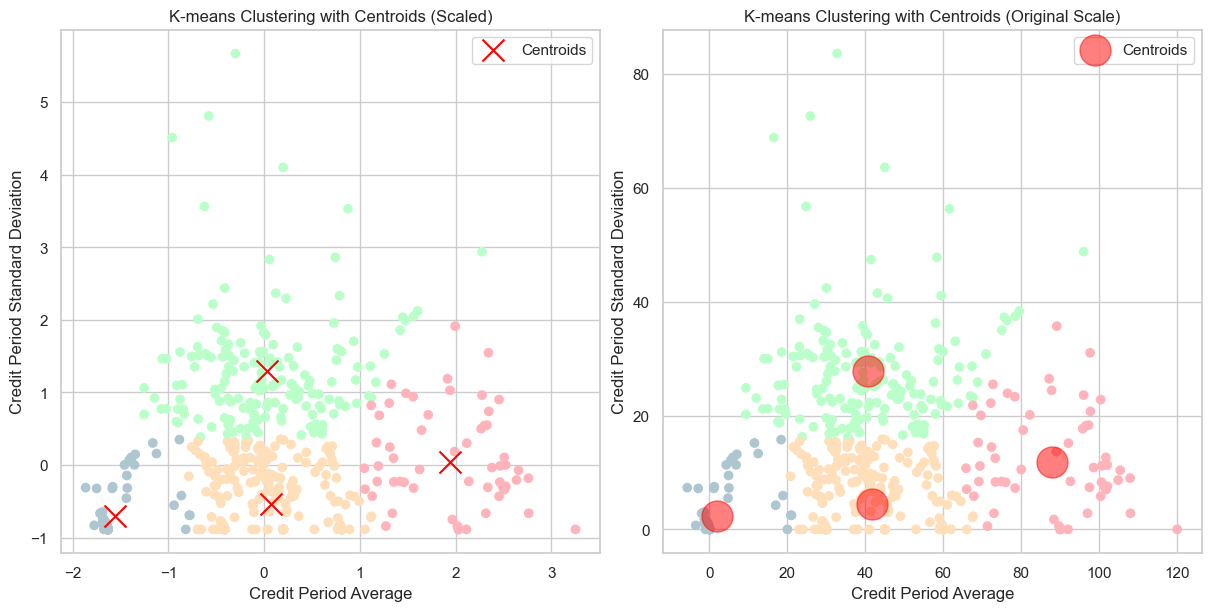

In [74]:
#plotting the centroids
from matplotlib.colors import ListedColormap

#defining a custom pastel color palette with slightly darker shades
custom_pastel = ListedColormap(["#aec6cf", "#ffb3ba", "#c2b2d6", "#ffdfba", "#baffc9"])

plt.figure(figsize=[12,6], layout='constrained')

#plot for scaled data
plt.subplot(1,2,1)
plt.scatter(pd_df_scaled['credit_period_avg'], pd_df_scaled['credit_period_sd'], c=kmeans.labels_, cmap=custom_pastel)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=250, c='red', label='Centroids')
plt.xlabel('Credit Period Average')
plt.ylabel('Credit Period Standard Deviation')
plt.legend()
plt.title('K-means Clustering with Centroids (Scaled)')

#plot for original scale data
plt.subplot(1,2,2)
plt.scatter(grouped_df['credit_period_avg'], grouped_df['credit_period_sd'], c=kmeans.labels_, cmap=custom_pastel)
plt.scatter(orig_centroids[:, 0], orig_centroids[:, 1], s=500, c='red', label='Centroids', alpha=0.5)
plt.xlabel('Credit Period Average')
plt.ylabel('Credit Period Standard Deviation')
plt.legend()
plt.title('K-means Clustering with Centroids (Original Scale)')

plt.show()

### Customer Segmentation Insights:
- There are 4 distinct clusters of customers with varying average credit periods and standard deviation.
- Most customers fall within an average credit period of 20 to 60 days, with moderate variability (Blue and Yellow clusters).
- Customers with an average credit period under 20 days show low variability in their credit usage, indicating consistent short-term credit users (Green cluster).
- Customers with an average credit period above 60 days have moderate variability, suggesting stable long-term borrowers (Yellow cluster).
- The highest variability is observed among customers with average credit periods of 20 to 40 days, indicating irregular or fluctuating credit patterns (Purple cluster).

# 4. Checking correlations of Numerical columns

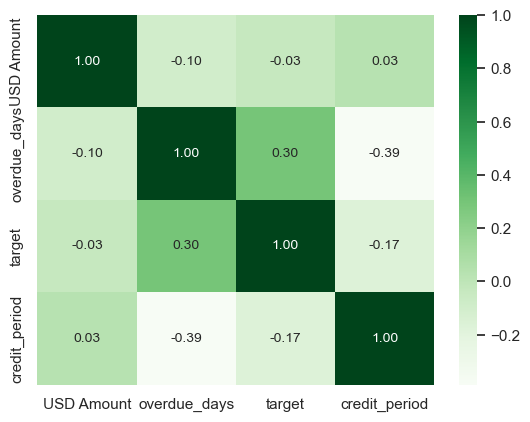

In [75]:
#list of numerical columns
num_col = ['USD Amount', 'overdue_days','target', 'credit_period']

#creating correlation matrix
num_col_corr = df1[num_col].corr()

#visualising heatmap
sns.heatmap(num_col_corr, fmt='.2f', annot=True, annot_kws={'size':10},cmap='Greens')
plt.show()

#### Key Insights from the Heatmap:

- Overdue Days and Default Risk: Customers with more overdue days are more likely to default.
- Credit Period and Overdue Days: Longer credit periods reduce the likelihood of overdue payments.
- Transaction Amount and Default Risk: Higher transaction amounts may be associated with a slightly increased risk of default.
- These insights can inform strategies for risk assessment, credit policy optimization, and targeted customer outreach.

# 5. Feature Engineering

- Let's now move on to feature engineering and create some dummies for our dataset's categorical variables

In [76]:
#displaying the first few rows of our dataframe
df1.head()

,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,overdue_days,target,credit_period
0,C EA Corp,2021-04-20,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,111,1,58
1,RADW Corp,2021-01-31,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,3,1,30
2,RADW Corp,2021-01-31,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,-29,0,30
3,FARO Corp,2021-01-31,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,1,30
4,RADW Corp,2021-01-31,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,17,1,30


In [77]:
#one-hot encoding the categorical columns without .astype(int)
ohe_cols = ['PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE']
df2 = pd.get_dummies(df1, columns=ohe_cols, drop_first=True)

#converting only the one-hot encoded columns to int
ohe_encoded_columns = df2.columns.difference(df1.columns)  # Identify the new columns
df2[ohe_encoded_columns] = df2[ohe_encoded_columns].astype(int)

#displaying the first few rows of the dataframe
df2.head()

,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_TYPE,overdue_days,target,credit_period,PAYMENT_TERM_120 Days from EOM,PAYMENT_TERM_120 Days from Inv Date,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_15 Days from Inv Date,PAYMENT_TERM_180 DAYS FROM INV DATE,PAYMENT_TERM_195 days from Invoice Date,PAYMENT_TERM_25 DAYS FROM EOM,"PAYMENT_TERM_25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE",PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_30% advance 70% after 30 days from invoice date,PAYMENT_TERM_30% advance 70% after 60 days from invoice date,PAYMENT_TERM_365 DAYS FROM INVOICE DATE,PAYMENT_TERM_40 DAYS FROM EOM,PAYMENT_TERM_45 DAYS + EOM,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_50% ADV 50% 30 Days,PAYMENT_TERM_50% ADVANCE PAYMENT AND 50% UPON RECEIVING THE SHIPMENT,PAYMENT_TERM_50% Advance 50% INVDATE+60 DAYS,PAYMENT_TERM_50% at 30 days and 50% at 60 days,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_7 Days from EOM,PAYMENT_TERM_7 Days from Inv Date,PAYMENT_TERM_75 Days from EOM,PAYMENT_TERM_75 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Advance with discount,PAYMENT_TERM_Cash Against Document at sight,PAYMENT_TERM_Cash on Delivery,PAYMENT_TERM_EOM,PAYMENT_TERM_Immediate,PAYMENT_TERM_Immediate Payment,PAYMENT_TERM_LC at 60 days,PAYMENT_TERM_LC at 60 days from FCR/AWB/BL date,PAYMENT_TERM_LC at 90 days,PAYMENT_TERM_LCSight,PAYMENT_TERM_On Consignment,PAYMENT_TERM_Standby LC at 30 days,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
0,C EA Corp,2021-04-20,101018.63040,2020-11-02,2020-12-30,Non Goods,111,1,58,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,RADW Corp,2021-01-31,48990.21133,2020-12-29,2021-01-28,Non Goods,3,1,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,RADW Corp,2021-01-31,41991.60971,2021-01-30,2021-03-01,Non Goods,-29,0,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,FARO Corp,2021-01-31,41991.60971,2020-12-15,2021-01-14,Non Goods,17,1,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,RADW Corp,2021-01-31,41991.60971,2020-12-15,2021-01-14,Non Goods,17,1,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


# 6. Checking Class Imbalance and Preparing Data for Model building

### 6.1 Checking class imbalance

In [78]:
#checking classs imbalance by checking % of delayed and not delayed from target column
df2['target'].value_counts(normalize=True)*100

target
1    65.978262
0    34.021738
Name: proportion, dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

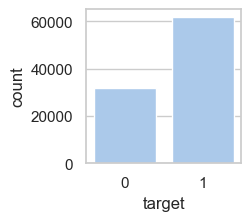

In [79]:
#visualizing the class imbalance
plt.figure(figsize=[2,2])
sns.countplot(x='target', data=df2)

We can see that the dataset is moderately imbalanced with around 66% delayed and 34% not delayed.

### 6.2 Data Preparation for building model

In [80]:
#dropping dates columns and overdue_days as it is not useful for working out on model
df3 = df2.drop(['CUSTOMER_NAME','RECEIPT_DATE','INVOICE_CREATION_DATE','DUE_DATE','INVOICE_TYPE','overdue_days'],axis=1)

#checking the shape
df3.shape

(93937, 55)

In [81]:
#displaying the first few rows of the dataframe 
df3.head()

,USD Amount,target,credit_period,PAYMENT_TERM_120 Days from EOM,PAYMENT_TERM_120 Days from Inv Date,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_15 Days from Inv Date,PAYMENT_TERM_180 DAYS FROM INV DATE,PAYMENT_TERM_195 days from Invoice Date,PAYMENT_TERM_25 DAYS FROM EOM,"PAYMENT_TERM_25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE",PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_30% advance 70% after 30 days from invoice date,PAYMENT_TERM_30% advance 70% after 60 days from invoice date,PAYMENT_TERM_365 DAYS FROM INVOICE DATE,PAYMENT_TERM_40 DAYS FROM EOM,PAYMENT_TERM_45 DAYS + EOM,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_50% ADV 50% 30 Days,PAYMENT_TERM_50% ADVANCE PAYMENT AND 50% UPON RECEIVING THE SHIPMENT,PAYMENT_TERM_50% Advance 50% INVDATE+60 DAYS,PAYMENT_TERM_50% at 30 days and 50% at 60 days,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_7 Days from EOM,PAYMENT_TERM_7 Days from Inv Date,PAYMENT_TERM_75 Days from EOM,PAYMENT_TERM_75 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Advance with discount,PAYMENT_TERM_Cash Against Document at sight,PAYMENT_TERM_Cash on Delivery,PAYMENT_TERM_EOM,PAYMENT_TERM_Immediate,PAYMENT_TERM_Immediate Payment,PAYMENT_TERM_LC at 60 days,PAYMENT_TERM_LC at 60 days from FCR/AWB/BL date,PAYMENT_TERM_LC at 90 days,PAYMENT_TERM_LCSight,PAYMENT_TERM_On Consignment,PAYMENT_TERM_Standby LC at 30 days,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
0,101018.63040,1,58,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,48990.21133,1,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,41991.60971,0,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,41991.60971,1,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,41991.60971,1,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


### 6.3 Train Test Split

In [82]:
#splitting the training and testing data
from sklearn.model_selection import train_test_split
y = df3.target
X = df3.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=56)

### 6.4 Feature Selection

In [83]:
#run random forest to get feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 25).fit(X_train, y_train)

feats = X_train.columns

for feature in zip(feats, rf.feature_importances_):
    print(feature)

('USD Amount', 0.5032197976593195)
('credit_period', 0.1804954713042977)
('PAYMENT_TERM_120 Days from EOM', 1.299165345703126e-05)
('PAYMENT_TERM_120 Days from Inv Date', 0.0003096372013565388)
('PAYMENT_TERM_15 Days from EOM', 0.016914615174081417)
('PAYMENT_TERM_15 Days from Inv Date', 0.00019652583331636385)
('PAYMENT_TERM_180 DAYS FROM INV DATE', 0.0)
('PAYMENT_TERM_195 days from Invoice Date', 9.35166254144314e-05)
('PAYMENT_TERM_25 DAYS FROM EOM', 0.0008074556870088568)
('PAYMENT_TERM_25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE', 5.583854564064058e-06)
('PAYMENT_TERM_30 Days from EOM', 0.0892821838573469)
('PAYMENT_TERM_30 Days from Inv Date', 0.009159917991860694)
('PAYMENT_TERM_30% advance 70% after 30 days from invoice date', 1.4593977227717129e-05)
('PAYMENT_TERM_30% advance 70% after 60 days from invoice date', 8.246259893964899e-05)
('PAYMENT_TERM_365 DAYS FROM INVOICE DATE', 2.8128180124915335e-05)
('PAYMENT_TERM_40 DAYS FROM EOM', 1.3512766610822817e-05)
('PAYMENT_TERM_45 

In [84]:
#sorting features descending to see the top ones
feat_low2high = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=True)
feat_low2high

PAYMENT_TERM_180 DAYS FROM INV DATE                                     0.000000e+00
PAYMENT_TERM_Standby LC at 30 days                                      4.718211e-07
PAYMENT_TERM_Advance with discount                                      5.934296e-07
PAYMENT_TERM_7 Days from EOM                                            1.209140e-06
PAYMENT_TERM_25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE                 5.583855e-06
PAYMENT_TERM_Cash Against Document at sight                             9.019815e-06
PAYMENT_TERM_120 Days from EOM                                          1.299165e-05
PAYMENT_TERM_40 DAYS FROM EOM                                           1.351277e-05
PAYMENT_TERM_30% advance 70% after 30 days from invoice date            1.459398e-05
PAYMENT_TERM_50% at 30 days and 50% at 60 days                          2.469933e-05
PAYMENT_TERM_365 DAYS FROM INVOICE DATE                                 2.812818e-05
PAYMENT_TERM_7 Days from Inv Date                                

In [85]:
#getting the top 10 features with the most importance
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp.nlargest(10)

USD Amount                            0.503220
credit_period                         0.180495
PAYMENT_TERM_30 Days from EOM         0.089282
PAYMENT_TERM_60 Days from EOM         0.072669
INVOICE_CURRENCY_CODE_SAR             0.034245
PAYMENT_TERM_15 Days from EOM         0.016915
INVOICE_CURRENCY_CODE_USD             0.015172
PAYMENT_TERM_Immediate Payment        0.010678
PAYMENT_TERM_60 Days from Inv Date    0.010581
PAYMENT_TERM_Immediate                0.010133
dtype: float64

In [86]:
#making list of top features which are >0.02, other can be dropped as it does not contribute much.
top_feat=feature_imp.nlargest(6).index.to_list()
top_feat

['USD Amount',
 'credit_period',
 'PAYMENT_TERM_30 Days from EOM',
 'PAYMENT_TERM_60 Days from EOM',
 'INVOICE_CURRENCY_CODE_SAR',
 'PAYMENT_TERM_15 Days from EOM']

In [87]:
#getting the dataframe with top features and target variable
df4 = df3[top_feat+ ['target']]
df4

,USD Amount,credit_period,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_60 Days from EOM,INVOICE_CURRENCY_CODE_SAR,PAYMENT_TERM_15 Days from EOM,target
0,101018.63040,58,1,0,0,0,1
1,48990.21133,30,0,0,1,0,1
2,41991.60971,30,0,0,1,0,0
3,41991.60971,30,0,0,1,0,1
4,41991.60971,30,0,0,1,0,1
...,...,...,...,...,...,...,...
93932,59914.50000,0,0,0,0,0,1
93933,59914.50000,0,0,0,0,0,1
93934,59914.50000,0,0,0,0,0,1
93935,23574.33000,59,0,0,0,0,1


# 7. Handling class imbalance
To optimize our model, we will experiment with various class imbalance techniques and algorithms. Our primary evaluation metric will be Recall, as accurately identifying customers likely to delay payments is crucial for early intervention.

In [88]:
#Train-Test split before trying various algorithms and class imbalance techniques
y = df4.target
X = df4.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=56)

### 7.1 Logistic regression

#### Logistic Regression - Base 

In [89]:
#fitting Logistic Regression - Base 
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [90]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train)

LogisticRegression()

In [91]:
y_pred = lreg.predict(X_test)

In [92]:
print ('\n classification report:\n', classification_report(y_test,y_pred))
print ('\n confusion matrix:\n',confusion_matrix(y_test, y_pred))


 classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9588
           1       0.66      0.99      0.79     18594

    accuracy                           0.66     28182
   macro avg       0.33      0.50      0.40     28182
weighted avg       0.43      0.66      0.52     28182


 confusion matrix:
 [[    0  9588]
 [  119 18475]]


#### Logistic Regression - Random Undersampling 

In [93]:
#fitting with Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
under_sample = RandomUnderSampler(random_state = 5)
X_resampled_us, y_resampled_us = under_sample.fit_resample(X_train, y_train)
len(X_resampled_us)

44742

In [94]:
print(sorted(Counter(y_resampled_us).items()))

[(0, 22371), (1, 22371)]


In [95]:
lreg_us = LogisticRegression()
lreg_us.fit(X_resampled_us, y_resampled_us)

y_pred_us = lreg_us.predict(X_test)

In [96]:
print ('\n classification report (Random undersampling):\n', classification_report(y_test,y_pred_us))
print ('\n confusion matrix (Random undersampling):\n',confusion_matrix(y_test, y_pred_us))


 classification report (Random undersampling):
               precision    recall  f1-score   support

           0       0.34      1.00      0.51      9588
           1       1.00      0.01      0.02     18594

    accuracy                           0.35     28182
   macro avg       0.67      0.50      0.26     28182
weighted avg       0.78      0.35      0.19     28182


 confusion matrix (Random undersampling):
 [[ 9588     0]
 [18419   175]]


#### Logistic Regression - Tomek Links 

In [97]:
#fitting logistic regression with Tomek Links
from imblearn.under_sampling import TomekLinks
tomek_sample = TomekLinks(sampling_strategy='majority')
X_resampled_tomek, y_resampled_tomek = tomek_sample.fit_resample(X_train, y_train)
len(X_resampled_tomek)

65355

In [98]:
print(sorted(Counter(y_resampled_tomek).items()))

[(0, 22371), (1, 42984)]


In [99]:
lreg_tomek = LogisticRegression()
lreg_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_tomek = lreg_tomek.predict(X_test)

In [100]:
print ('\n classification report (Tomek Links):\n', classification_report(y_test,y_pred_tomek))
print ('\n confusion matrix (Tomek Links):\n',confusion_matrix(y_test, y_pred_tomek))


 classification report (Tomek Links):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9588
           1       0.66      0.99      0.79     18594

    accuracy                           0.66     28182
   macro avg       0.33      0.50      0.40     28182
weighted avg       0.43      0.66      0.52     28182


 confusion matrix (Tomek Links):
 [[    0  9588]
 [  119 18475]]


#### Logistic Regression - Random Oversampling 

In [101]:
#fitting with Random OverSampling
from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)
len(X_resampled_os)

86768

In [102]:
print(sorted(Counter(y_resampled_os).items()))

[(0, 43384), (1, 43384)]


In [103]:
lreg_os = LogisticRegression()
lreg_os.fit(X_resampled_os, y_resampled_os)

y_pred_os = lreg_os.predict(X_test)

In [104]:
print ('\n classification report (Random OverSampling):\n', classification_report(y_test,y_pred_os))
print ('\n confusion matrix (Random OverSampling):\n',confusion_matrix(y_test, y_pred_os))


 classification report (Random OverSampling):
               precision    recall  f1-score   support

           0       0.34      1.00      0.51      9588
           1       1.00      0.01      0.02     18594

    accuracy                           0.35     28182
   macro avg       0.67      0.50      0.26     28182
weighted avg       0.78      0.35      0.19     28182


 confusion matrix (Random OverSampling):
 [[ 9588     0]
 [18419   175]]


#### Logistic Regression - SMOTE 

In [105]:
#using SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=45, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train, y_train)
len(X_resampled_smt)

86768

In [106]:
print(sorted(Counter(y_resampled_smt).items()))

[(0, 43384), (1, 43384)]


In [107]:
lreg_smt = LogisticRegression()
lreg_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_smt = lreg_smt.predict(X_test)

In [108]:
print ('\n classification report (SMOTE):\n', classification_report(y_test,y_pred_smt))
print ('\n confusion matrix (SMOTE):\n',confusion_matrix(y_test, y_pred_smt))


 classification report (SMOTE):
               precision    recall  f1-score   support

           0       0.34      1.00      0.51      9588
           1       1.00      0.01      0.02     18594

    accuracy                           0.35     28182
   macro avg       0.67      0.50      0.26     28182
weighted avg       0.78      0.35      0.19     28182


 confusion matrix (SMOTE):
 [[ 9588     0]
 [18419   175]]


#### Logistic Regression - ADASYN 

In [109]:
#using ADASYN
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
len(X_resampled_ada)

87811

In [110]:
print(sorted(Counter(y_resampled_ada).items()))

[(0, 44427), (1, 43384)]


In [111]:
lreg_ada = LogisticRegression()
lreg_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_ada = lreg_ada.predict(X_test)

In [112]:
print ('\n classification report (ADASYN):\n', classification_report(y_test,y_pred_ada))
print ('\n confusion matrix (ADASYN):\n',confusion_matrix(y_test, y_pred_ada))


 classification report (ADASYN):
               precision    recall  f1-score   support

           0       0.11      0.00      0.00      9588
           1       0.66      0.99      0.79     18594

    accuracy                           0.65     28182
   macro avg       0.38      0.50      0.40     28182
weighted avg       0.47      0.65      0.52     28182


 confusion matrix (ADASYN):
 [[   24  9564]
 [  191 18403]]


#### Logistic Regression - SMOTE+TOMEK 

In [113]:
#using SMOTE+TOMEK
from imblearn.combine import SMOTETomek
smt_tmk = SMOTETomek(random_state=45)
X_resampled_smt_tmk, y_resampled_smt_tmk = smt_tmk.fit_resample(X_train, y_train)
len(X_resampled_smt_tmk)

85940

In [114]:
print(sorted(Counter(y_resampled_smt_tmk).items()))

[(0, 42970), (1, 42970)]


In [115]:
lreg_smt_tmk = LogisticRegression()
lreg_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_smt_tmk = lreg_smt_tmk.predict(X_test)

In [116]:
print ('\n classification report (SMOTE+TOMEK):\n', classification_report(y_test,y_pred_smt_tmk))
print ('\n confusion matrix (SMOTE+TOMEK):\n',confusion_matrix(y_test, y_pred_smt_tmk))


 classification report (SMOTE+TOMEK):
               precision    recall  f1-score   support

           0       0.34      1.00      0.51      9588
           1       1.00      0.01      0.02     18594

    accuracy                           0.35     28182
   macro avg       0.67      0.50      0.26     28182
weighted avg       0.78      0.35      0.19     28182


 confusion matrix (SMOTE+TOMEK):
 [[ 9588     0]
 [18419   175]]


# 7.2 Random Forest

#### Random Forest - Base

In [117]:
#fitting Random Forest - Base model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [118]:
print ('\n classification report:\n', classification_report(y_test,y_pred_rf))
print ('\n confusion matrix:\n',confusion_matrix(y_test, y_pred_rf))


 classification report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      9588
           1       0.89      0.94      0.91     18594

    accuracy                           0.88     28182
   macro avg       0.88      0.86      0.87     28182
weighted avg       0.88      0.88      0.88     28182


 confusion matrix:
 [[ 7533  2055]
 [ 1200 17394]]


In [119]:
# Random Forest - Random UnderSampling
rf_us = RandomForestClassifier()
rf_us.fit(X_resampled_us, y_resampled_us)

y_pred_rf_us = rf_us.predict(X_test)

In [120]:
print ('\n classification report (Random UnderSampling):\n', classification_report(y_test,y_pred_rf_us))
print ('\n confusion matrix (Random UnderSampling):\n',confusion_matrix(y_test, y_pred_rf_us))


 classification report (Random UnderSampling):
               precision    recall  f1-score   support

           0       0.78      0.86      0.81      9588
           1       0.92      0.87      0.90     18594

    accuracy                           0.87     28182
   macro avg       0.85      0.86      0.86     28182
weighted avg       0.87      0.87      0.87     28182


 confusion matrix (Random UnderSampling):
 [[ 8218  1370]
 [ 2380 16214]]


#### Random Forest - Tomek Links

In [121]:
#fitting Random Forest - Tomek Links
rf_tomek = RandomForestClassifier()
rf_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_rf_tomek = rf_tomek.predict(X_test)

In [122]:
print ('\n classification report (Tomek Links):\n', classification_report(y_test,y_pred_rf_tomek))
print ('\n confusion matrix (Tomek Links):\n',confusion_matrix(y_test, y_pred_rf_tomek))


 classification report (Tomek Links):
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      9588
           1       0.90      0.93      0.91     18594

    accuracy                           0.88     28182
   macro avg       0.88      0.86      0.87     28182
weighted avg       0.88      0.88      0.88     28182


 confusion matrix (Tomek Links):
 [[ 7571  2017]
 [ 1245 17349]]


#### Random Forest - Random Over-Sampling

In [123]:
#Random Forest - Random Over-Sampling
rf_os = RandomForestClassifier()
rf_os.fit(X_resampled_os, y_resampled_os)

y_pred_rf_os = rf_os.predict(X_test)

In [124]:
print ('\n classification report (Random Over-Sampling):\n', classification_report(y_test,y_pred_rf_os))
print ('\n confusion matrix (Random Over-Sampling):\n',confusion_matrix(y_test, y_pred_rf_os))


 classification report (Random Over-Sampling):
               precision    recall  f1-score   support

           0       0.81      0.84      0.83      9588
           1       0.92      0.90      0.91     18594

    accuracy                           0.88     28182
   macro avg       0.86      0.87      0.87     28182
weighted avg       0.88      0.88      0.88     28182


 confusion matrix (Random Over-Sampling):
 [[ 8069  1519]
 [ 1866 16728]]


#### Random Forest - SMOTE

In [125]:
#Random Forest - SMOTE
rf_smt = RandomForestClassifier()
rf_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_rf_smt = rf_smt.predict(X_test)

In [126]:
print ('\n classification report (SMOTE):\n', classification_report(y_test,y_pred_rf_smt))
print ('\n confusion matrix (SMOTE):\n',confusion_matrix(y_test, y_pred_rf_smt))


 classification report (SMOTE):
               precision    recall  f1-score   support

           0       0.80      0.85      0.83      9588
           1       0.92      0.89      0.91     18594

    accuracy                           0.88     28182
   macro avg       0.86      0.87      0.87     28182
weighted avg       0.88      0.88      0.88     28182


 confusion matrix (SMOTE):
 [[ 8126  1462]
 [ 1979 16615]]


#### Random Forest - ADASYN

In [127]:
#Random Forest - ADASYN
rf_ada = RandomForestClassifier()
rf_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_rf_ada = rf_ada.predict(X_test)

In [128]:
print ('\n classification report (ADASYN):\n', classification_report(y_test,y_pred_rf_ada))
print ('\n confusion matrix (ADASYN):\n',confusion_matrix(y_test, y_pred_rf_ada))


 classification report (ADASYN):
               precision    recall  f1-score   support

           0       0.73      0.90      0.80      9588
           1       0.94      0.83      0.88     18594

    accuracy                           0.85     28182
   macro avg       0.83      0.86      0.84     28182
weighted avg       0.87      0.85      0.85     28182


 confusion matrix (ADASYN):
 [[ 8589   999]
 [ 3213 15381]]


#### Random Forest - SMOTE+TOMEK

In [129]:
#Random Forest - SMOTE+TOMEK
rf_smt_tmk = RandomForestClassifier()
rf_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_rf_smt_tmk = rf_smt_tmk.predict(X_test)

In [130]:
print ('\n classification report (SMOTE+TOMEK):\n', classification_report(y_test,y_pred_rf_smt_tmk))
print ('\n confusion matrix (SMOTE+TOMEK):\n',confusion_matrix(y_test, y_pred_rf_smt_tmk))


 classification report (SMOTE+TOMEK):
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      9588
           1       0.92      0.89      0.91     18594

    accuracy                           0.88     28182
   macro avg       0.86      0.87      0.87     28182
weighted avg       0.88      0.88      0.88     28182


 confusion matrix (SMOTE+TOMEK):
 [[ 8141  1447]
 [ 2014 16580]]


### Summary of the algorithms and class imbalance techniques

												
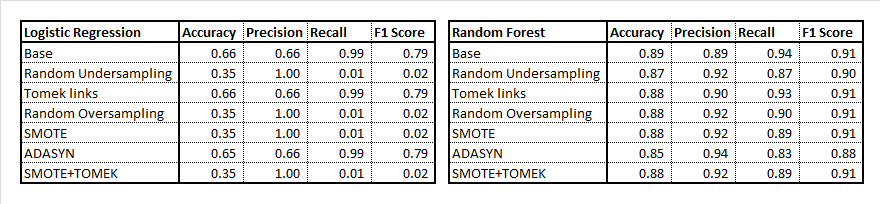

- The Base model (without implementing any class imbalance technique) and Tomek links produced the best results compared to other class imbalance methods.

- The Random Forest model demonstrated significantly higher performance, achieving superior Accuracy, Precision, Recall, and F1 Score.

- Logistic Regression exhibited better Recall than Random Forest but had lower Accuracy and Precision.

- Based on these observations, we will proceed with the Random Forest model without applying any class imbalance techniques.

- The dataset is not highly skewed, with 66% of instances representing delayed payments and 34% representing non-delayed payments.

# 8. Model Building

### 8.1 Random Forest Model

In [131]:
#instantiate RandomForest
rf = RandomForestClassifier(random_state=42, n_estimators=50, oob_score=True)

#fitting train data 
rf.fit(X_train, y_train)

#predicting y_train data from RandomForest model
y_train_pred = rf.predict(X_train)

#checking accuracy of train data
accuracy_score(y_train, y_train_pred)

0.942650748992472

In [132]:
#predicting y_test data from RandomForest model
y_test_pred = rf.predict(X_test)

#checking accuracy of Test data
accuracy_score(y_test, y_test_pred)

0.8848200979348521

In [133]:
#getting evaluation metric and confusion matrix
print ('\n classification report:\n', classification_report(y_test,y_test_pred))
print ('\n confusion matrix:\n',confusion_matrix(y_test, y_test_pred))


 classification report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      9588
           1       0.89      0.94      0.91     18594

    accuracy                           0.88     28182
   macro avg       0.88      0.86      0.87     28182
weighted avg       0.88      0.88      0.88     28182


 confusion matrix:
 [[ 7544  2044]
 [ 1202 17392]]


### 8.2 Hyperparameter Tuning

#### GridSearchCV

In [134]:
#importing library for finding optimal parameters using GridSearch
from sklearn.model_selection import GridSearchCV

In [135]:
#instantiating RandomForest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [136]:
#defining different values for the hyper parameters for searching best combination
hyper_params = {'max_depth': [10, 15, 20],
                'max_features': [2,4,6],
                'min_samples_leaf': [20, 50, 100],
                'n_estimators': [25, 50, 75]
               }

In [137]:
#instantiating a 4 fold GridSearch for given hyperparameters
model_cv = GridSearchCV(estimator=rf, 
             param_grid=hyper_params,
             verbose=1,
             cv=4,
             n_jobs=-1,
             return_train_score=True)

In [138]:
#fitting different values on Train data
model_cv.fit(X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20], 'max_features': [2, 4, 6],
                         'min_samples_leaf': [20, 50, 100],
                         'n_estimators': [25, 50, 75]},
             return_train_score=True, verbose=1)

In [139]:
#getting best score
model_cv.best_score_

0.8465364189588261

In [140]:
#getting best combination of parameters 
rf_best_cv = model_cv.best_estimator_
rf_best_cv

RandomForestClassifier(max_depth=20, max_features=6, min_samples_leaf=20,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [141]:
#predicting on test dataset 
y_test_pred = rf_best_cv.predict(X_test)

In [142]:
#getting evaluation metric and confusion matrix
print ('\n classification report:\n', classification_report(y_test,y_test_pred))
print ('\n confusion matrix:\n',confusion_matrix(y_test, y_test_pred))


 classification report:
               precision    recall  f1-score   support

           0       0.84      0.69      0.76      9588
           1       0.85      0.93      0.89     18594

    accuracy                           0.85     28182
   macro avg       0.84      0.81      0.82     28182
weighted avg       0.85      0.85      0.84     28182


 confusion matrix:
 [[ 6595  2993]
 [ 1282 17312]]


#### Fine tuning 

In [143]:
#fine tuning of parameters
hyper_params = {'max_depth': [15, 20, 25],
                'max_features': [6],
                'min_samples_leaf': [20, 25, 30],
                'n_estimators': [50,75]
               }

In [144]:
#instantiating 4 fold GridSearch for fine tuning of hyperparameters
model_cv2 = GridSearchCV(estimator=rf, 
             param_grid=hyper_params,
             verbose=1,
             cv=4,
             n_jobs=-1,
             return_train_score=True)

In [145]:
#fitting different values on Train data
model_cv2.fit(X_train, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25], 'max_features': [6],
                         'min_samples_leaf': [20, 25, 30],
                         'n_estimators': [50, 75]},
             return_train_score=True, verbose=1)

In [146]:
#getting the best score 
model_cv2.best_score_

0.8472207634545588

In [147]:
#getting the best parameters after fine tuning
model_cv2.best_estimator_

RandomForestClassifier(max_depth=25, max_features=6, min_samples_leaf=20,
                       n_estimators=50, n_jobs=-1, random_state=42)

### 8.3 Finalizing The Model

In [148]:
#selecting best parameters out of the two models model_cv and model_cv2
rf_best = model_cv2.best_estimator_
rf_best

RandomForestClassifier(max_depth=25, max_features=6, min_samples_leaf=20,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [149]:
#predicting on Test data based on parameters obtained from fine tuning
y_test_pred = rf_best.predict(X_test)

In [150]:
#checking the evaluation metrics for rf_best
print ('\n classification report:\n', classification_report(y_test,y_test_pred))
print ('\n confusion matrix:\n',confusion_matrix(y_test, y_test_pred))


 classification report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      9588
           1       0.86      0.93      0.89     18594

    accuracy                           0.85     28182
   macro avg       0.85      0.81      0.82     28182
weighted avg       0.85      0.85      0.85     28182


 confusion matrix:
 [[ 6665  2923]
 [ 1319 17275]]


- We will finalize the model `rf_best` for future use because it demonstrates very high accuracy, precision, recall, and F1-score.  

- The recall is especially high, indicating that the model effectively predicts a significant proportion of delayed payments.

## Conclusion

The developed classification model, based on the Random Forest algorithm, demonstrates strong performance in predicting customer payment behavior.

**Key Performance Metrics:**

* **Accuracy:** The model accurately predicts 85% of cases.
* **Precision:** The model correctly identifies 83% of customers as not delayed and 86% as delayed.
* **Recall:** The model correctly identifies 70% of customers who are not delayed and 93% of customers who are delayed.
* **F1-Score:** The model achieves an F1-score of 0.76 for not delayed customers and 0.89 for delayed customers, indicating a good balance between precision and recall.

**Model Implications:**

* **Effective Customer Segmentation:** The model can be used to identify customers at risk of payment delays, enabling targeted interventions and personalized strategies.
* **Improved Decision-Making:** By accurately predicting customer behavior, businesses can optimize their credit and collection processes, reducing losses and improving cash flow.
* **Enhanced Customer Relationships:** Proactive outreach to customers at risk of delay can strengthen customer relationships and prevent negative consequences.


# 9. Applying Model on Open Invoice Data

### 9.1 Reading Data, Data Cleaning and Data Preparation

In [151]:
#reading the open invoice dataset
odata = pd.read_csv('Open_Invoice_data.csv',encoding='latin1')

#displaying the first few rows of the dataframe
odata.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [152]:
#checking for null values
odata.isna().sum()

AS_OF_DATE              0
Customer Type           0
Customer_Name           0
Customer Account No     3
Transaction Number      9
Transaction Date        0
Payment Term            0
Due Date                0
Transaction Currency    0
Local Amount            0
Transaction Class       0
AGE                     0
USD Amount              0
INV_CREATION_DATE       0
dtype: int64

We do see there are a few null values in the dataframe

In [153]:
#getting information about datatypes and data composition in the dataset
odata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


In [154]:
#removing rows for which prediction is not required
odata_pred=odata[odata['AGE']<=0]

#displaying the first few rows of the dataframe
odata_pred.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30
5,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000106,03/03/2022,30 Days from EOM,30/04/2022,AED,"1,264",INVOICE,-25,"1,264",3/3/2022 22:30
6,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000124,15/03/2022,30 Days from EOM,30/04/2022,AED,"25,858",INVOICE,-25,"25,858",3/15/2022 19:06
7,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000125,15/03/2022,30 Days from EOM,30/04/2022,AED,"39,873",INVOICE,-25,"39,873",3/15/2022 19:06


In [155]:
#removing redundant columns to aid our analysis
odata1 = odata_pred.drop(['AS_OF_DATE', 'Customer Type', 'Customer Account No',
       'Transaction Number', 'Transaction Date', 'Local Amount'],axis=1)

In [156]:
#converting USD Amount to float
odata1['USD Amount'] = odata1['USD Amount'].str.replace(',', '').astype(float)

In [157]:
#converting date columns to date time format
odata1[['Due Date','INV_CREATION_DATE']] = odata1[['Due Date','INV_CREATION_DATE']].apply(pd.to_datetime)

In [158]:
#adding credit_period indicating number of days from invoice date to due date
odata1['credit_period'] = (odata1['Due Date']-odata1['INV_CREATION_DATE']).dt.days

#displaying the first few rows of the dataframe
odata1.head()

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,credit_period
2,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INVOICE,-18,2000.0,2022-03-24 17:46:00,29
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,3800.0,2022-03-03 22:30:00,57
5,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,1264.0,2022-03-03 22:30:00,57
6,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,25858.0,2022-03-15 19:06:00,45
7,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,39873.0,2022-03-15 19:06:00,45


In [159]:
#renaming columns to match with model features
odata2 = odata1.rename(columns={'Customer_Name':'CUSTOMER_NAME','Payment Term':'PAYMENT_TERM','Due Date':'DUE_DATE', 
                         'Transaction Currency':'INVOICE_CURRENCY_CODE','INV_CREATION_DATE':'INVOICE_CREATION_DATE',
                          'Transaction Class':'INVOICE_CLASS'})
#displaying first few rows of the dataframe
odata2.head()

,CUSTOMER_NAME,PAYMENT_TERM,DUE_DATE,INVOICE_CURRENCY_CODE,INVOICE_CLASS,AGE,USD Amount,INVOICE_CREATION_DATE,credit_period
2,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INVOICE,-18,2000.0,2022-03-24 17:46:00,29
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,3800.0,2022-03-03 22:30:00,57
5,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,1264.0,2022-03-03 22:30:00,57
6,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,25858.0,2022-03-15 19:06:00,45
7,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,39873.0,2022-03-15 19:06:00,45


In [160]:
#using One Hot Encoding to encode our categorical columns like we did before
ohe_cols = ['PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE']
odata3 = pd.get_dummies(odata2,columns=ohe_cols,drop_first=True)

#displaying first few rows of the dataframe
odata3.head()

,CUSTOMER_NAME,DUE_DATE,AGE,USD Amount,INVOICE_CREATION_DATE,credit_period,PAYMENT_TERM_120 Days from Inv Date,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_15 Days from Inv Date,PAYMENT_TERM_180 DAYS FROM INV DATE,PAYMENT_TERM_25 DAYS FROM EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_30% advance 70% after 60 days from invoice date,PAYMENT_TERM_365 DAYS FROM INVOICE DATE,PAYMENT_TERM_40 DAYS FROM EOM,PAYMENT_TERM_45 DAYS + EOM,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_50% ADV 50% 30 Days,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_70 days from Invoice Date,PAYMENT_TERM_75 Days from EOM,PAYMENT_TERM_75 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_LC at 60 days,INVOICE_CLASS_INVOICE,INVOICE_CLASS_PAYMENT,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EGP,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_HKD,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_OMR,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_SGD,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
2,AL J Corp,2022-04-23,-18,2000.0,2022-03-24 17:46:00,29,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,ALLI Corp,2022-04-30,-25,3800.0,2022-03-03 22:30:00,57,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,ALLI Corp,2022-04-30,-25,1264.0,2022-03-03 22:30:00,57,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,ALLI Corp,2022-04-30,-25,25858.0,2022-03-15 19:06:00,45,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,ALLI Corp,2022-04-30,-25,39873.0,2022-03-15 19:06:00,45,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [161]:
#keeping the features selected during model development 
odata4 = odata3[top_feat]

#displaying first few rows of the dataframe
odata4.head()

,USD Amount,credit_period,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_60 Days from EOM,INVOICE_CURRENCY_CODE_SAR,PAYMENT_TERM_15 Days from EOM
2,2000.0,29,False,False,False,False
4,3800.0,57,True,False,False,False
5,1264.0,57,True,False,False,False
6,25858.0,45,True,False,False,False
7,39873.0,45,True,False,False,False


In [162]:
#predicting the target (i.e. delay in payment = 1, no delay in payment =0) for Open Invoice data
pred_target = rf_best.predict(odata4)
pred_target

array([1, 0, 0, ..., 1, 1, 1])

In [163]:
#Adding the target column in original Open invoice dataset (filtered for rows which requires prediction)
odata_pred['target'] = pred_target

## Complete Dataset with Target Column

In [164]:
#complete dataset with target column
odata_pred

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,target
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46,1
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30,0
5,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000106,03/03/2022,30 Days from EOM,30/04/2022,AED,"1,264",INVOICE,-25,"1,264",3/3/2022 22:30,0
6,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000124,15/03/2022,30 Days from EOM,30/04/2022,AED,"25,858",INVOICE,-25,"25,858",3/15/2022 19:06,0
7,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000125,15/03/2022,30 Days from EOM,30/04/2022,AED,"39,873",INVOICE,-25,"39,873",3/15/2022 19:06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88172,04-APR-2022 01:07:01,3rd Party,MIDD Corp,20867.0,165220000039,30/03/2022,60 Days from Inv Date,29/05/2022,USD,"3,435",INVOICE,-54,"3,435",3/30/2022 11:10,1
88186,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136.0,165220000032,07/03/2022,60 Days from Inv Date,06/05/2022,USD,"114,039",INVOICE,-31,"114,039",3/7/2022 9:58,1
88187,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136.0,165220000034,17/03/2022,60 Days from Inv Date,16/05/2022,USD,"32,138",INVOICE,-41,"32,138",3/17/2022 8:21,1
88188,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136.0,165220000035,18/03/2022,60 Days from Inv Date,17/05/2022,USD,"26,764",INVOICE,-42,"26,764",3/18/2022 10:48,1


# Conclusion:

Following are top 10 contributors for delayed payments
- USD Amount                            0.502804
- credit_period                         0.151758
- PAYMENT_TERM_30 Days from EOM         0.106410
- PAYMENT_TERM_60 Days from EOM         0.079946
- INVOICE_CURRENCY_CODE_SAR             0.026825
- PAYMENT_TERM_15 Days from EOM         0.024857
- PAYMENT_TERM_Immediate Payment        0.015835
- INVOICE_CURRENCY_CODE_USD             0.014700
- PAYMENT_TERM_30 Days from Inv Date    0.010389
- PAYMENT_TERM_Immediate                0.010206

## Recommendation:
Clients should consider implementing milestone or staggered invoicing rather than waiting to invoice the entire order amount at once. This approach can enhance cash flow management, reduce financial risk, and improve project tracking.



Here are some advantageous payment terms to consider:



1. **Payment Term: 180 Days from Invoice Date**  

   Allows the client extended time to manage cash flow before payment is due.



2. **Payment Term: Advance Payment with Discount**  

   Offering a discount for advance payments can incentivize timely cash flow and reduce outstanding receivables.



3. **Payment Term: 120 Days from End of Month (EOM)**  

   Provides a longer payment window, which can be beneficial for clients with longer project timelines.



4. **Payment Term: 7 Days from End of Month (EOM)**  

   This is ideal for shorter project durations, encouraging prompt payment.



5. **Payment Term: Standby Letter of Credit (LC) at 30 Days**  

   This provides an added layer of security for both parties, ensuring funds are available upon invoice approval.



When considering payment terms, it's essential to remain cautious with the following:



1. **Payment Term: 30 Days from End of Month (EOM)**  

   While commonly used, this term can create cash flow challenges if clients experience delays.



2. **Payment Term: 60 Days from End of Month (EOM)**  

   A longer payment window can lead to extended periods of uncertainty regarding cash collection.



Regarding invoice currency codes, the following are recommended:



1. **Currency Code: ZAR (South African Rand)**  

   A favorable option for transactions within South Africa.



2. **Currency Code: QAR (Qatari Rial)**  

   Useful for clients dealing in or with Qatar.



3. **Currency Code: GBP (British Pound)**  

   Ideal for transactions with UK clients or partners.



However, caution should be exercised when using the following currency codes:



1. **Currency Code: SAR (Saudi Riyal)**  

   Payment delays or currency fluctuations can impact the final amount received.



2. **Currency Code: USD (United States Dollar)**  

   While widely used, currency exchange rates can fluctuate significantly, impacting profitability.



Additionally, consider the following best practices:



- **Define Clear Payment Schedules**: Understanding when each milestone is achieved and the corresponding payment due can help align expectations.



- **Communicate Promptly**: Keep lines of communication open with clients regarding invoices and payment statuses.



- **Utilize Payment Reminders**: Automated reminders for upcoming payments can reduce delays and improve cash flow.



- **Incorporate Late Payment Fees**: Clearly stating late fees in contracts can provide an incentive for timely payment.



By establishing clear invoicing practices and optimal payment terms, clients can foster stronger financial relationships and enhance overall project success.

#### Thank You!